# Installing Julia and Jupyter


* Copy the data files and the ipynb file on your computer (and remember where you put them ☺)
* Download and install Julia from http://julialang.org/downloads/
* Open Julia and enter the following commands:

```julia
using Pkg
Pkg.add("IJulia")
Pkg.add("PyPlot")
Pkg.add("PhysOcean")
# to install the developpement version use this command
#Pkg.clone("https://github.com/gher-ulg/PhysOcean.jl")
```

* Note that some commands may take some time to execute.
* Load the IJulia package and start the Jupyter notebook interface

```julia
using IJulia
notebook()
```

* This opens the web-browser with a Jupyter session or adds a new tab into an existing browser window

* Navigate through the directories and open the file `Ocean Heat Fluxes.ipynb`

* Jupyter supports Chrome, Safari and Firefox. Internet Explorer is not recommended
(http://jupyter-notebook.readthedocs.io/en/latest/notebook.html#browser-compatibility)


# Exercise on Air-Sea fluxes

We are going to calculate the air-sea fluxes on the Bay of Calvi during one year (2016) using a combination of in situ data (from the meteorological station in Stareso) and modeled data (when no in situ data are available). The names of the files read indicate if they come from a model (ECMWF) or not.

If working on the Virtual Macine, you need to install one package (the Pkg.add("PhysOcean") line in the cell below) before you can call it.


In [1]:
#uncomment the two first lines if PhysOcean is not installed in the virtual machine
#using Pkg
#Pkg.add("PhysOcean")
using PyPlot
using PhysOcean
using DelimitedFiles
using Statistics
using Dates

In [2]:
#We are now going to download all necessary files from dox

filename = "solrad.csv";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/h5vfLDkOQpMQdnB/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "albedoECMWF.txt";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/Syn1221wZ8eR9KF/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "airtemp.csv";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/JhQCD5lDpD30gqP/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "tccECMWF.txt";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/tIQe4sYftzP3AsZ/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "rhECMWF.txt";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/gXELajKkTagXFJL/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "watertemp_calvi.txt";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/UqUvDoqVFrTXf01/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "windspeed.csv";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/NVm4fabFwSId8vf/download"),filename)
else
    @info("$filename is already downloaded")
end

filename = "atmpress.csv";
if !isfile(filename)
    @info("downloading $filename")
    cp(download("https://dox.uliege.be/index.php/s/028JlDsTYxheOti/download"),filename)
else
    @info("$filename is already downloaded")
end


┌ Info: solrad.csv is already downloaded
└ @ Main In[2]:8
┌ Info: albedoECMWF.txt is already downloaded
└ @ Main In[2]:16
┌ Info: airtemp.csv is already downloaded
└ @ Main In[2]:24
┌ Info: tccECMWF.txt is already downloaded
└ @ Main In[2]:32
┌ Info: rhECMWF.txt is already downloaded
└ @ Main In[2]:40
┌ Info: watertemp_calvi.txt is already downloaded
└ @ Main In[2]:48
┌ Info: windspeed.csv is already downloaded
└ @ Main In[2]:56
┌ Info: atmpress.csv is already downloaded
└ @ Main In[2]:64


## Solar flux

In order to calculate the solar flux, we need to know the incoming radiation (measured at Stareso) and the albedo (from teh model ECMWF).

In [3]:
Q = readdlm("solrad.csv");#(W/m²)
@show size(Q)
Q = Q[:,1];

# set all negative values to zero 
Q[Q .< 0] .= 0;

data_albedo = readdlm("albedoECMWF.txt");
al = data_albedo[:,1];
date = datetime_matlab.(data_albedo[:,2]);

Qs = solarflux.(Q,al);
size(Qs)
@show date[1:10]

size(Q) = (22749, 3)
date[1:10] = DateTime[2016-01-01T00:02:00, 2016-01-01T00:22:00, 2016-01-01T00:42:00, 2016-01-01T01:02:00, 2016-01-01T01:22:00, 2016-01-01T01:42:00, 2016-01-01T02:02:00, 2016-01-01T02:22:00, 2016-01-01T02:42:00, 2016-01-01T03:02:00]


10-element Array{DateTime,1}:
 2016-01-01T00:02:00
 2016-01-01T00:22:00
 2016-01-01T00:42:00
 2016-01-01T01:02:00
 2016-01-01T01:22:00
 2016-01-01T01:42:00
 2016-01-01T02:02:00
 2016-01-01T02:22:00
 2016-01-01T02:42:00
 2016-01-01T03:02:00

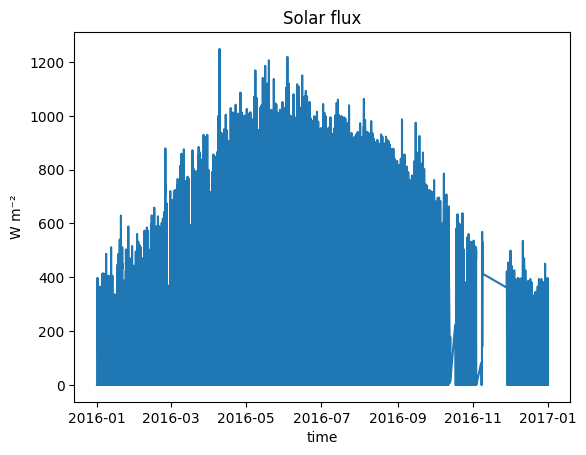

PyObject Text(0.5, 1.0, 'Solar flux')

In [22]:
plot(date,Qs);
ylabel("W m⁻²");
xlabel("time");
title("Solar flux")

$\rightarrow$ What do you observe? How is the solar flux changing with time?

$\rightarrow$ Compare the solar flux in a winter day with one in a summer day (make a new plot below)

In [5]:
#Make your plot in this cell comparing the solar flux magnitude in winter and in summer

## Longwave flux

We now calculate the longwave flux. If you recall from the equation given in class, we will need the air and water temperature, the total cloud cover and the relative humidity.

In [6]:
Ta = readdlm("airtemp.csv");
Ta = Ta[:,1];

tcc = readdlm("tccECMWF.txt");
tcc = tcc[:,1];
#tcc = (tcc*0)+1;

r = readdlm("rhECMWF.txt");
r = r[:,1];

ep = vaporpressure.(Ta);#Ta in C
ep = ep.*r;

Ts = readdlm("watertemp_calvi.txt");
#Ts = Ts[1:30915,1];
Ts = Ts[:,1];
Ts[Ts.==9999].=NaN;
@show size(Ts) size(ep) size(r) size(tcc) size(Ta)
Qb = longwaveflux.(Ts,Ta,ep,tcc);#Ta in C

size(Ts) = (22749,)
size(ep) = (22749,)
size(r) = (22749,)
size(tcc) = (22749,)
size(Ta) = (22749,)


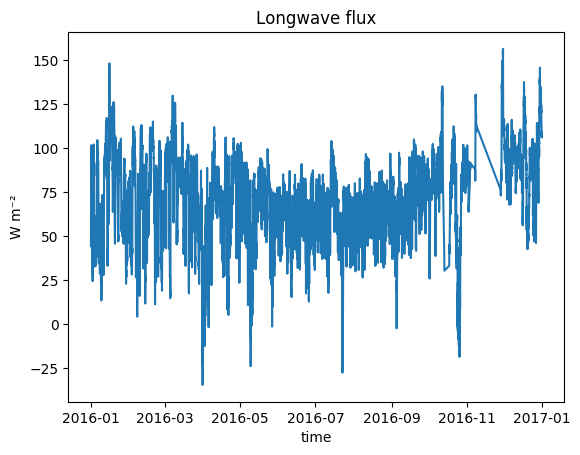

PyObject Text(0.5, 1.0, 'Longwave flux')

In [23]:
plot(date,Qb);
ylabel("W m⁻²");
xlabel("time");
title("Longwave flux")

What do you think that the straight line at the end of 2016 is? Chech the input variables to see where this comes from

## Sensible heat flux

Which variables do we need to calculate the sensible heat flux? (some have already been read above we do not need to read them again)

In [8]:
w = readdlm("windspeed.csv");
w = w[:,1];
@show size(w)
#Ta = readdlm("airtemp.csv");
#Ta = Ta[:,1];
#@show size(Ts)
#Ts = readdlm("watertemp_calvi.csv");

Qc = sensibleflux.(Ts,Ta,w);

size(w) = (22749,)


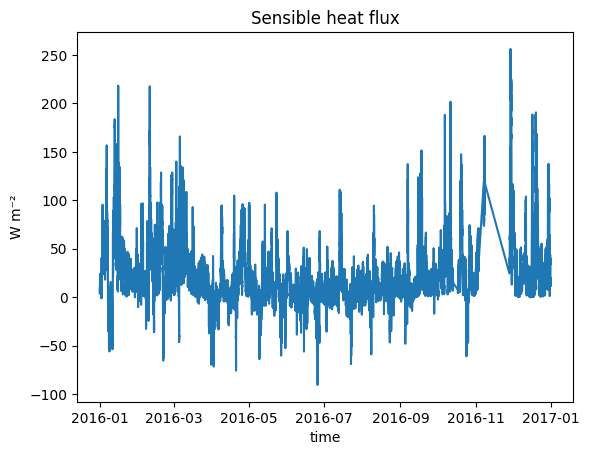

PyObject Text(0.5, 1.0, 'Sensible heat flux')

In [24]:
plot(date,Qc);
ylabel("W m⁻²");
xlabel("time");
title("Sensible heat flux")

## Latent heat flux

In [10]:
pa = readdlm("atmpress.csv");
pa = pa[:,1];

Qe = latentflux.(Ts,Ta,r,w,pa); 

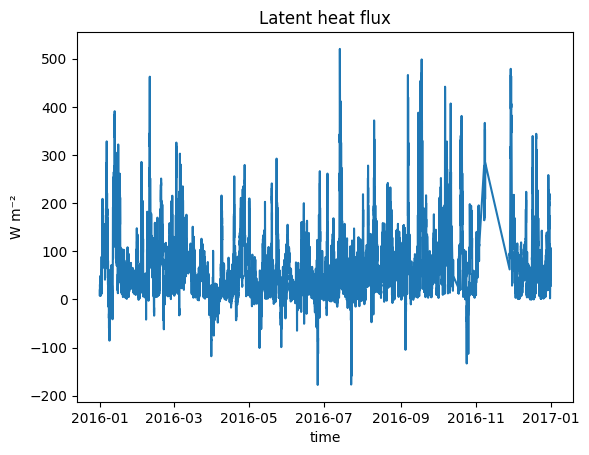

PyObject Text(0.5, 1.0, 'Latent heat flux')

In [25]:
plot(date,Qe);
ylabel("W m⁻²");
xlabel("time");
title("Latent heat flux")

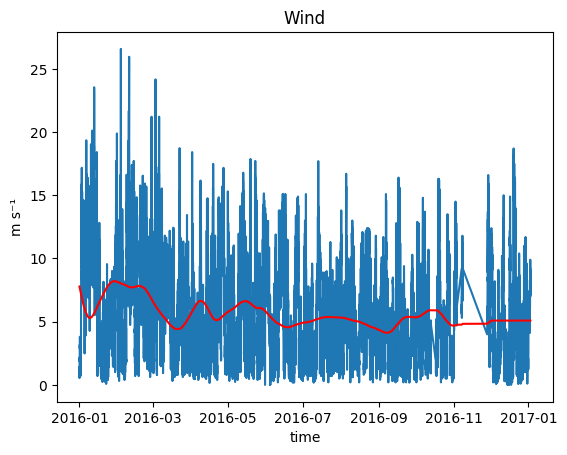

PyObject Text(0.5, 1.0, 'Wind')

In [29]:
#Here a little exercise: we visualise wind speed, and a filtered version of the wind speed to see long-term changes
# The function gaussfilter (xd = gaussfilter(x,WW) ) performs a Gaussian filtering with a window width of WW
#Parameter WW in the units of the input dataset

wd = gaussfilter(w,3*30*24); #20-minute time step * 3 = 1hour; *24 = 1 day * 30 = 1 month filter length
plot(date,w,label ="Wind")
#hold(true)
plot(date,wd,"r",label ="1-month filter");
ylabel("m s⁻¹");
xlabel("time");
title("Wind")

## Daily averages

We are going to average the heat fluxes time series. In this example we do daily averages.

In [13]:
date = readdlm("rhECMWF.txt");#(W/m²)
date = datetime_matlab.(date[:,2]);
@show date[1:10]

date[1:10] = DateTime[2016-01-01T00:02:00, 2016-01-01T00:22:00, 2016-01-01T00:42:00, 2016-01-01T01:02:00, 2016-01-01T01:22:00, 2016-01-01T01:42:00, 2016-01-01T02:02:00, 2016-01-01T02:22:00, 2016-01-01T02:42:00, 2016-01-01T03:02:00]


10-element Array{DateTime,1}:
 2016-01-01T00:02:00
 2016-01-01T00:22:00
 2016-01-01T00:42:00
 2016-01-01T01:02:00
 2016-01-01T01:22:00
 2016-01-01T01:42:00
 2016-01-01T02:02:00
 2016-01-01T02:22:00
 2016-01-01T02:42:00
 2016-01-01T03:02:00

In [14]:
#We look for all indices of time in a given day, and average all values at those indices 
s=1;

floor_date = Dates.Date.(date);
#floor_date = [floor(d,Dates.Day) for d in date]
date_daily = minimum(floor_date):Dates.Day(1):maximum(floor_date)

ndates = length(date_daily)
Qsd = zeros(ndates)
Qbd = zeros(ndates)
Qcd = zeros(ndates)
Qed = zeros(ndates)

for i = date_daily
    Qsd[s] = mean(Qs[floor_date .== i]);
    Qbd[s] = mean(Qb[floor_date .== i]);
    Qcd[s] = mean(Qc[floor_date .== i]);
    Qed[s] = mean(Qe[floor_date .== i]);
    s=s+1;
end
@show date_daily[1:10]

date_daily[1:10] = 2016-01-01:1 day:2016-01-10


2016-01-01:1 day:2016-01-10

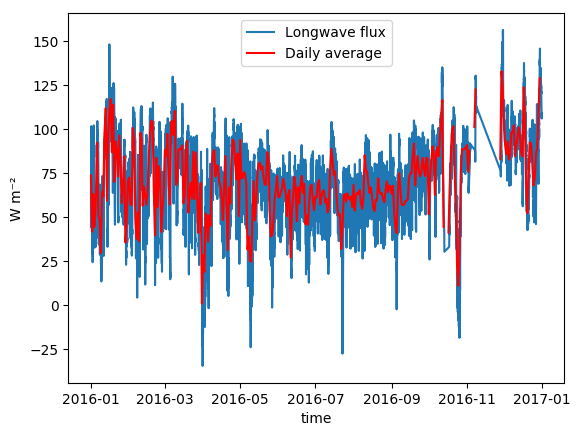

In [15]:
plot(date,Qb,label ="Longwave flux")
#hold(true)
plot(date_daily,Qbd,"r",label ="Daily average");
ylabel("W m⁻²");
xlabel("time");
legend();

$\rightarrow$ Try visualizing other components of the heat fluxes and their filtered version

## Monthly averages

Same exercice, but with monthly averages

In [16]:
m = Dates.month.(date)
dates_monthly = DateTime(2016,1,15):Dates.Month(1):DateTime(2016,12,15);

Qsm = zeros(12)
Qbm = zeros(12)
Qcm = zeros(12)
Qem = zeros(12)

for i = 1:12
    Qsm[i] = nanmean(Qs[m .== i]);
    Qbm[i] = nanmean(Qb[m .== i]);
    Qcm[i] = nanmean(Qc[m .== i]);
    Qem[i] = nanmean(Qe[m .== i]);
end


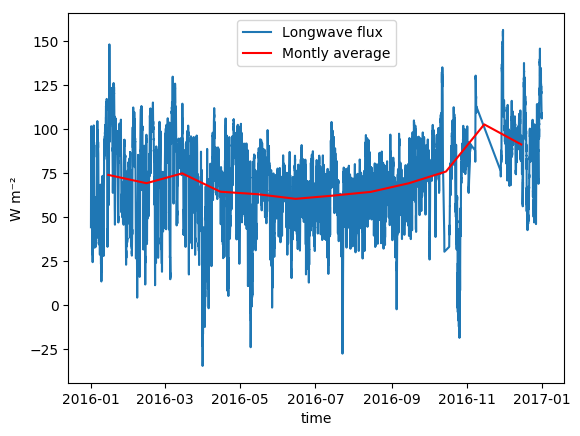

In [17]:
plot(date,Qb,label ="Longwave flux")
#hold(true)
plot(dates_monthly,Qbm,"r",label ="Montly average");
ylabel("W m⁻²");
xlabel("time");
legend();

$\rightarrow$ Try this monthly average for other components of the heat fluxes

## Total flux

Now that we have the 4 components of the air-sea heat fluxes, we can calculate the total heat flux

In [37]:
Qi = Qs -(Qb+Qe+Qc);
low = 1*30*24; #what is the length of this filter in days? 

Qif = gaussfilter(Qi,low);
Qsf = gaussfilter(Qs,low);
Qbf = gaussfilter(Qb,low);
Qcf = gaussfilter(Qc,low);
Qef = gaussfilter(Qe,low);
@show low

low = 720


720

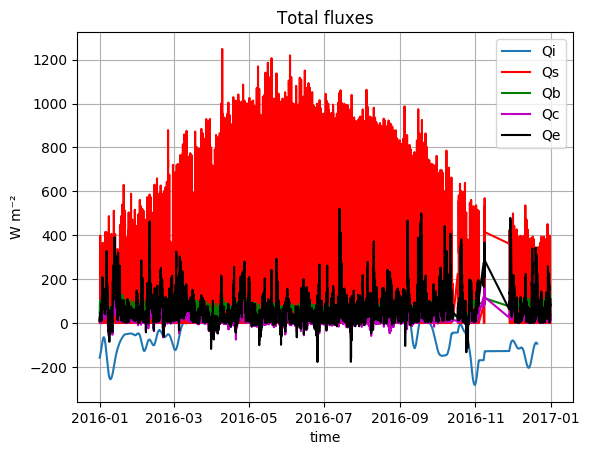

PyObject Text(0.5, 1.0, 'Total fluxes')

In [38]:
# plot of the raw fluxes (with no filtering)
figure()
plot(date,Qif,label="Qi")
# datetick("x")
grid("on")
#hold(true)
plot(date,Qs,"r")
plot(date,Qb,"g")
plot(date,Qc,"m")
plot(date,Qe,"k")
legend(["Qi","Qs","Qb","Qc","Qe"]);
ylabel("W m⁻²");
xlabel("time");
title("Total fluxes")

$\rightarrow$ Now make the same plot but with different filter lengths, to see the effect of the filtering in the data, and also to better see the different curves. Do a plot with 3-month filtering and 6-month filtering